C:\Users\wzhon\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\wzhon\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Successful Matches:
  Average distance: nan miles
  Median distance: nan miles

Failed Matches:
  Average distance: 7.36 miles
  Median distance: 5.96 miles


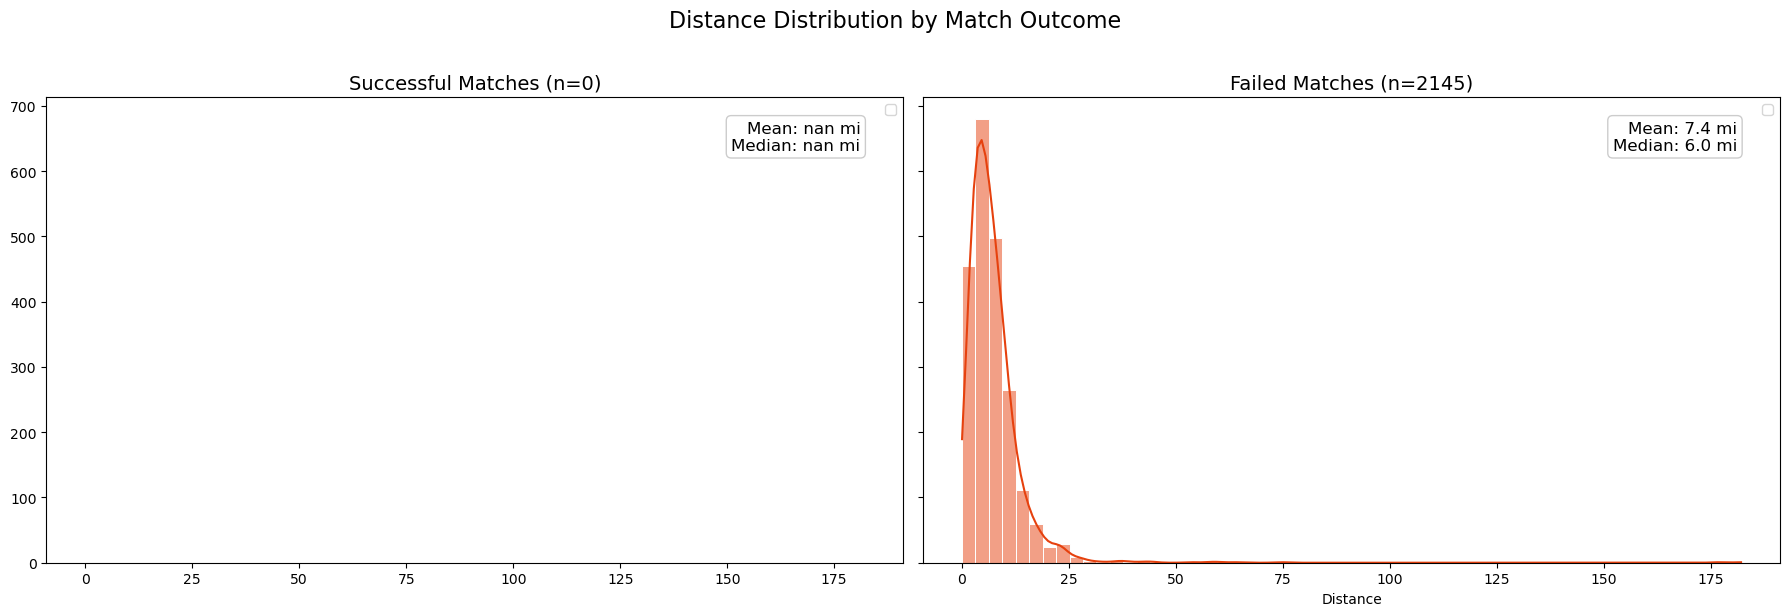


--- Statistical Comparison ---


ValueError: Data must be at least length 3.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load and prepare data
df = pd.read_csv('results1.csv')
df['time'] = df['Match Length']

success_conditions = (df['is_successful'] == 'TRUE')
df['event'] = np.where(success_conditions, 0, 1)

df_clean = df.dropna(subset=['Distance','Little Mailing Address Census Block Group','Big Home Census Block Group'])

# Split into success/failure groups
success_df = df_clean[df_clean['event'] == 0]
fail_df = df_clean[df_clean['event'] == 1]

# Successful matches histogram
success_stats = {
    'mean': success_df['Distance'].mean(),
    'median': success_df['Distance'].median()
}

fail_stats = {
    'mean': fail_df['Distance'].mean(),
    'median': fail_df['Distance'].median()
}

# Print to console
print("Successful Matches:")
print(f"  Average distance: {success_stats['mean']:.2f} miles")
print(f"  Median distance: {success_stats['median']:.2f} miles\n")

print("Failed Matches:")
print(f"  Average distance: {fail_stats['mean']:.2f} miles")
print(f"  Median distance: {fail_stats['median']:.2f} miles")

# Modified plotting code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)

# Successful matches plot
sns.histplot(success_df['Distance'], kde=True, bins=58, 
            color=(0.055, 0.753, 0.902), edgecolor='white', ax=ax1)
ax1.set_title(f'Successful Matches (n={len(success_df)})', fontsize=14)
ax1.legend()
ax1.annotate(f"Mean: {success_stats['mean']:.1f} mi\nMedian: {success_stats['median']:.1f} mi",
             xy=(0.95, 0.95), xycoords='axes fraction',
             ha='right', va='top', fontsize=12,
             bbox=dict(boxstyle='round', alpha=0.2, facecolor='white'))

# Failed matches plot
sns.histplot(fail_df['Distance'], kde=True, bins=58, 
            color=(0.902, 0.255, 0.055), edgecolor='white', ax=ax2)
ax2.set_title(f'Failed Matches (n={len(fail_df)})', fontsize=14)
ax2.legend()
ax2.annotate(f"Mean: {fail_stats['mean']:.1f} mi\nMedian: {fail_stats['median']:.1f} mi",
             xy=(0.95, 0.95), xycoords='axes fraction',
             ha='right', va='top', fontsize=12,
             bbox=dict(boxstyle='round', alpha=0.2, facecolor='white'))

plt.suptitle('Distance Distribution by Match Outcome', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

#-----------------------------------------------------------------------------------
#Statistical Analysis
#-----------------------------------------------------------------------------------

def compare_groups(success, fail):
    # Normality test
    _, p_success = stats.shapiro(success)
    _, p_fail = stats.shapiro(fail)
    
    print("Normality Test (Shapiro-Wilk):")
    print(f"  Successful matches p-value: {p_success:.4f}")
    print(f"  Failed matches p-value: {p_fail:.4f}")
    
    # Choose test based on normality
    if p_success > 0.05 and p_fail > 0.05:
        print("\nUsing Student's t-test (parametric):")
        t_stat, p_value = stats.ttest_ind(success, fail)
        print(f"  t-statistic: {t_stat:.2f}, p-value: {p_value:.4f}")
        
        # Calculate Cohen's d effect size
        pooled_std = np.sqrt((np.std(success)**2 + np.std(fail)**2)/2)
        cohen_d = (np.mean(fail) - np.mean(success))/pooled_std
        print(f"  Cohen's d: {cohen_d:.2f}")
    else:
        print("\nUsing Mann-Whitney U test (non-parametric):")
        u_stat, p_value = stats.mannwhitneyu(success, fail)
        print(f"  U-statistic: {u_stat:.0f}, p-value: {p_value:.4f}")
        
        # Calculate Rank-Biserial Correlation effect size
        n1, n2 = len(success), len(fail)
        rbc = 1 - (2*u_stat)/(n1*n2)
        print(f"  Rank-Biserial r: {rbc:.2f}")

# Run comparison
print("\n--- Statistical Comparison ---")
compare_groups(success_df['Distance'], fail_df['Distance'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='event', y='Distance', data=df_clean)
plt.title('Distance Distribution with Outliers')
plt.show()

def remove_outliers(df, column='Distance'):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from both groups
success_clean = remove_outliers(success_df)
fail_clean = remove_outliers(fail_df)

# New sample sizes
print(f"Original Successful: {len(success_df)} | Cleaned: {len(success_clean)}")
print(f"Original Failed: {len(fail_df)} | Cleaned: {len(fail_clean)}")

# Re-run statistical tests
print("\n--- Without Outliers ---")
compare_groups(success_clean['Distance'], fail_clean['Distance'])

# Replot distributions
plt.figure(figsize=(12, 6))
sns.boxplot(x='event', y='Distance', data=pd.concat([success_clean, fail_clean]))
plt.title('Distance Distribution After Outlier Removal')
plt.show()

# Calculate new statistics after outlier removal
success_stats_clean = {
    'mean': success_clean['Distance'].mean(),
    'median': success_clean['Distance'].median()
}

fail_stats_clean = {
    'mean': fail_clean['Distance'].mean(),
    'median': fail_clean['Distance'].median()
}

# Create enhanced histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)

# Successful matches plot (without outliers)
sns.histplot(success_clean['Distance'], kde=True, bins=50, 
            color=(0.055, 0.753, 0.902), edgecolor='white', ax=ax1)
ax1.set_title(f'Successful Matches (Without Outliers)\nn = {len(success_clean)}', fontsize=14, pad=15)
ax1.annotate(f"Mean: {success_stats_clean['mean']:.1f} mi\nMedian: {success_stats_clean['median']:.1f} mi",
             xy=(0.95, 0.90), xycoords='axes fraction',
             ha='right', va='top', fontsize=12,
             bbox=dict(boxstyle='round', alpha=0.2, facecolor='white'))

# Failed matches plot (without outliers)
sns.histplot(fail_clean['Distance'], kde=True, bins=50, 
            color=(0.902, 0.255, 0.055), edgecolor='white', ax=ax2)
ax2.set_title(f'Failed Matches (Without Outliers)\nn = {len(fail_clean)}', fontsize=14, pad=15)
ax2.annotate(f"Mean: {fail_stats_clean['mean']:.1f} mi\nMedian: {fail_stats_clean['median']:.1f} mi",
             xy=(0.95, 0.90), xycoords='axes fraction',
             ha='right', va='top', fontsize=12,
             bbox=dict(boxstyle='round', alpha=0.2, facecolor='white'))

# Formatting
plt.suptitle('Distance Distributions After Outlier Removal (IQR Method)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

C:\Users\wzhon\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wzhon\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\wzhon\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


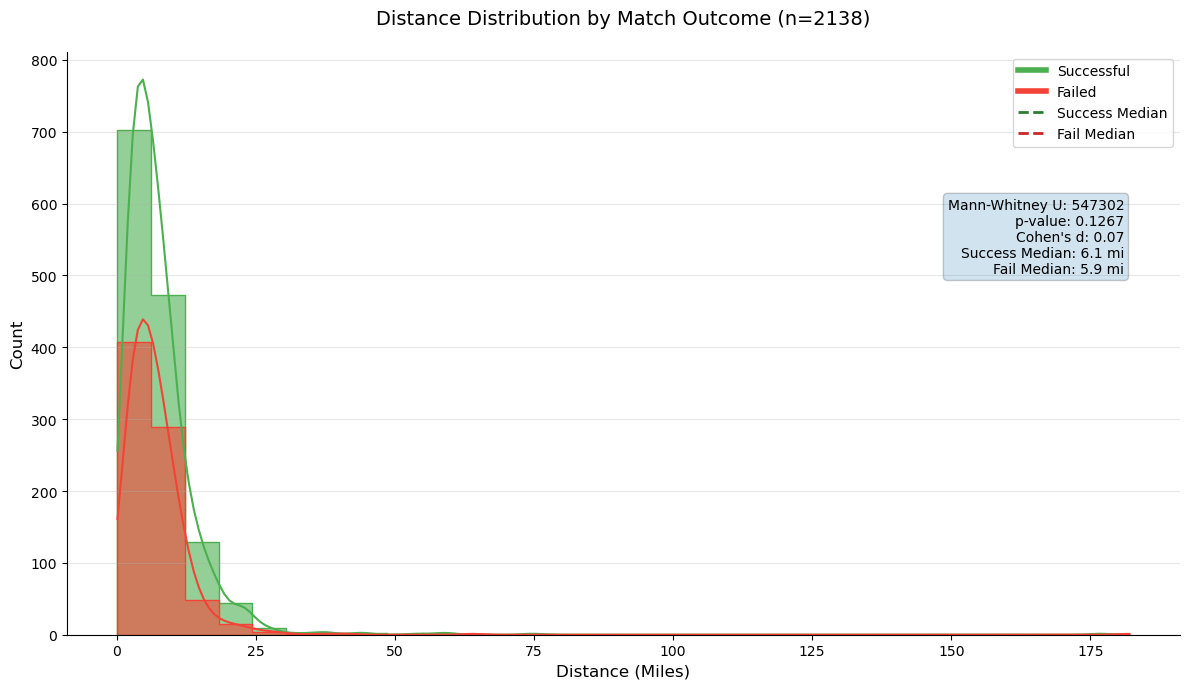

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

# Load and clean data
df = pd.read_csv('results1.csv')
filtered_df = df[
    (df['Distance'].notna()) &
    (df['closure_reason_grp'] != '') &
    (df['is_successful'].isin([True, False]))
].copy()

# Convert Distance to numeric and clean
filtered_df['Distance'] = pd.to_numeric(filtered_df['Distance'], errors='coerce')
filtered_df = filtered_df.dropna(subset=['Distance'])
filtered_df = filtered_df[filtered_df['Distance'] > 0]  # Remove negative distances

# Create histogram
plt.figure(figsize=(12, 7))
ax = sns.histplot(
    data=filtered_df,
    x='Distance',
    hue='is_successful',
    element='step',
    bins=30,
    palette={True: '#4CAF50', False: '#F44336'},
    kde=True,
    alpha=0.6
)

# Add median lines and annotations
success_median = filtered_df[filtered_df['is_successful'] == True]['Distance'].median()
fail_median = filtered_df[filtered_df['is_successful'] == False]['Distance'].median()

# Statistical analysis
success_dist = filtered_df[filtered_df['is_successful'] == True]['Distance']
fail_dist = filtered_df[filtered_df['is_successful'] == False]['Distance']

# Mann-Whitney U test
stat, p = mannwhitneyu(success_dist, fail_dist)

# Effect size calculation
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

d = cohens_d(success_dist, fail_dist)

# Format plot
plt.title(f'Distance Distribution by Match Outcome (n={len(filtered_df)})', pad=20, fontsize=14)
plt.xlabel('Distance (Miles)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Create legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#4CAF50', lw=4, label='Successful'),
    Line2D([0], [0], color='#F44336', lw=4, label='Failed'),
    Line2D([0], [0], color='#2E7D32', linestyle='--', lw=2, label='Success Median'),
    Line2D([0], [0], color='#C62828', linestyle='--', lw=2, label='Fail Median')
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1))

# Add statistical annotations
stats_text = f"""Mann-Whitney U: {stat:.0f}
p-value: {p:.4f}
Cohen's d: {d:.2f}
Success Median: {success_median:.1f} mi
Fail Median: {fail_median:.1f} mi"""

plt.text(0.95, 0.75, stats_text,
         transform=ax.transAxes,
         ha='right', va='top',
         bbox=dict(boxstyle='round', alpha=0.2))

sns.despine()
plt.tight_layout()
plt.show()